# Лабораторная работа №3
# Использование механизмов внимания в нейронных сетях
## ББМО-01-22 Загороднов Егор Алексеевич

In [ ]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Загрузим модель

После того как установили tf-keras-vis приступаем к загрузке модели VGG16. Модель VGG16 является одной из самых популярных моделей для обработки изображений. Она обладает высокой точностью и способна распознавать большое количество объектов.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 15s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

### Загрузим и предобработаем изображения

После того, как мы успешно погрузили модель, приступаем к процессу загрузки и предобработке изображений. В данном случае, tf-keras-vis поддерживает визуализацию нескольких изображений одновременно, поэтому мы выбрали четыре различных изображения для загрузки и обработки: акулу, петуха, кукурузу и туалетную бумагу.



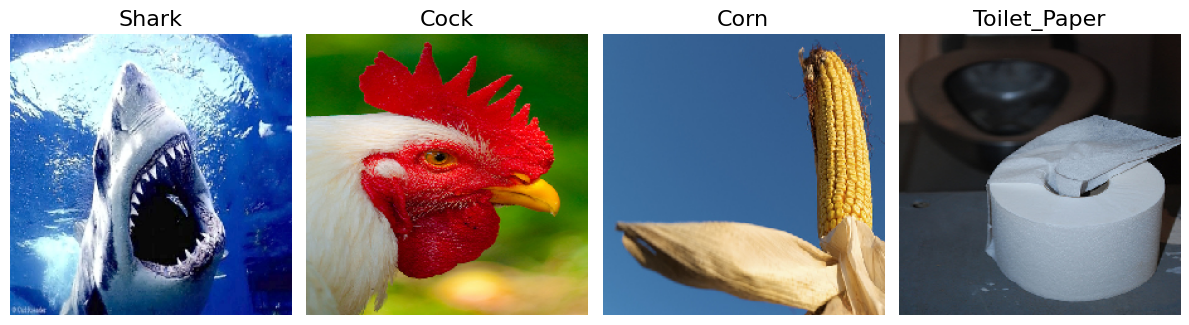

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input


image_titles = ['Shark', 'Cock', 'Corn', 'Toilet_Paper']

# Загружаем изображения и конвертируем их в массив Numpy
img1 = load_img('shark_2.JPEG', target_size=(224, 224))
img2 = load_img('cock_7.JPEG', target_size=(224, 224))
img3 = load_img('corn_987.JPEG', target_size=(224, 224))
img4 = load_img('toilet_paper_999.JPEG', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Подготавливаем входы для VGG16
X = preprocess_input(images)


f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Реализация функций, необходимых для использования внимания
### Модификатор модели

Приступаем к реализации функций, необходимых для использования внимания. Если вместо функции активации softmax мы используем функцию линейной активации в последнем слое модели, это поможет улучшить способность модели создавать точки внимания на изображениях. Для замены функции активации мы можем создать экземпляр класса ReplaceToLinear, который будет выполнять эту задачу. Однако, помимо этого, нам также доступна возможность использования функции модификатора модели, которую мы определили самостоятельно. Это позволяет нам более гибко контролировать и настраивать процесс модификации модели для достижения оптимальных результатов.

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Функция расчета
Как альтернативу функции активации softmax, мы можем использовать функцию линейной активации в последнем слое модели, чтобы избежать возможных проблем с созданием изображений внимания. Для этого мы создаем экземпляр ReplaceToLinear, который позволяет нам заменить функцию активации на линейную. Кроме использования ReplaceToLinear, мы также можем использовать функцию модификатора модели, которую мы определили сами, чтобы изменять `score function`. В данном случае, `score function` возвращает количество очков, соответствующее каждому из элементов - акуле, петуху, кукурузе и туалетной бумаге.


In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 308 - акула, 309 - петух, 310 - кукуруза и 333 - туалетная бумага.
score = CategoricalScore([308, 309, 310, 333])


def score_function(output):
    return (output[0][308], output[1][309], output[2][310], output[3][333])

## Ванильное внимание

`Saliency` используется для создания карты внимания, которая выделяет наиболее важные области входного изображения, которые влияют на окончательный результат. Карта визуализирует области на изображении, которые имеют наибольшее влияние на выходные значения алгоритма. Карта внимания может помочь нам понять, какие части изображения являются ключевыми для получения нужного результата.

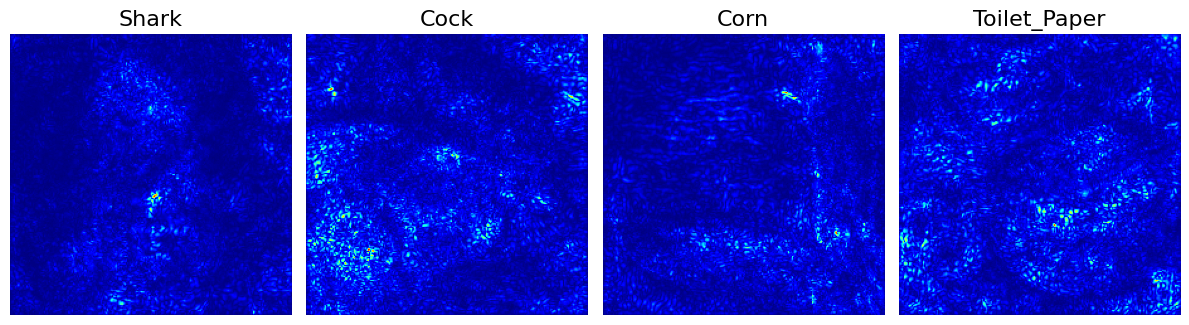

CPU times: user 5.4 s, sys: 1.61 s, total: 7.01 s
Wall time: 13.5 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Создаем объект внимания
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Генерируем карту внимания
saliency_map = saliency(score, X)


f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## SmoothGrad

Генерация карты внимания, при которой выделяются области на входном изображении с наибольшим воздействием на выходное значение, предоставляет возможность выделить важные элементы.
Для улучшения качества карты значимости можно применить метод SmoothGrad, который позволяет уменьшить шум на карте, добавляя шум к входному изображению. Это поможет получить более точное представление о влиянии каждой области на итоговый результат.


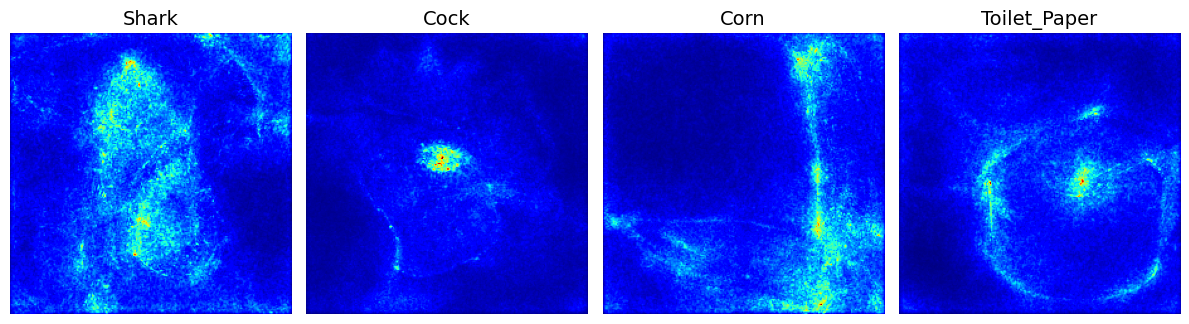

CPU times: user 2.43 s, sys: 248 ms, total: 2.68 s
Wall time: 3.79 s


In [ ]:
%%time

# Генерируем карту внимания со сглаживанием, которое уменьшает шум за счет добавления шума
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # Количество итераций
                        smooth_noise=0.20) # уровень распространения шума.
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

## GradCAM

GradCAM представляет собой альтернативный способ визуализации внимания к входным данным. В отличие от использования градиентов вывода модели, он использует данные вывода предпоследнего слоя - сверточного слоя, находящегося непосредственно перед плотными слоями. Этот подход позволяет получить более детальную информацию о том, какие области изображения привлекли наибольшее внимание модели.
GradCAM представляет собой альтернативный способ визуализации внимания к входным данным. В отличие от использования градиентов вывода модели, он использует данные вывода предпоследнего слоя - сверточного слоя, находящегося непосредственно перед плотными слоями. Этот подход позволяет получить более детальную информацию о том, какие области изображения привлекли наибольшее внимание модели.
Как видно из рисунка, метод GradCAM предоставляет полезную интуитивную информацию о том, на чем сфокусировано внимание. Тем не менее, при более внимательном рассмотрении видно, что отображаемое внимание не охватывает всю цель на изображении.

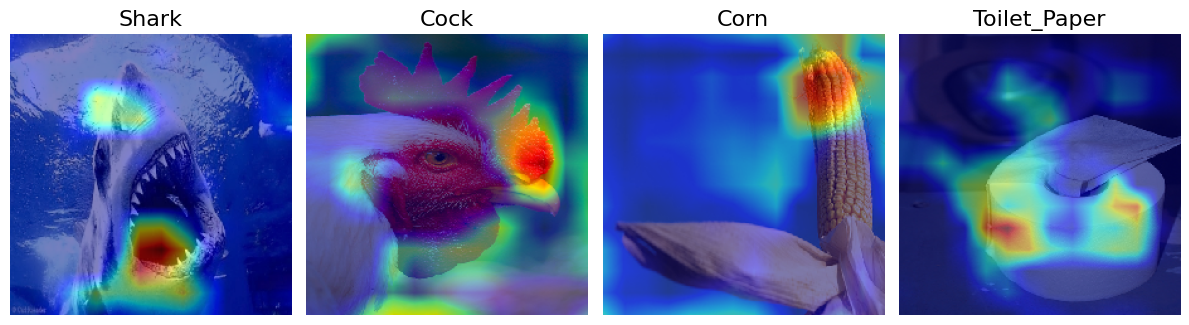

CPU times: user 1.53 s, sys: 800 ms, total: 2.33 s
Wall time: 2.22 s


In [ ]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Создаем объект Gradcam
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Генерируем тепловую карту с GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## GradCAM++

GradCAM++ может обеспечить лучшее визуальное объяснение прогнозов модели, чем GradCAM. Он предоставляет более точное отображение внимания на объекты на изображении, полностью покрывая цель. Этот метод основан на более сложных вычислениях и учитывает более широкий контекст изображения, что делает его более надежным и информативным визуальным объяснением прогнозов модели CNN. Таким образом, использование GradCAM++ может быть предпочтительным в ситуациях, где мы хотим получить более детальное и полное представление о том, на чем модель сосредотачивает свое внимание.

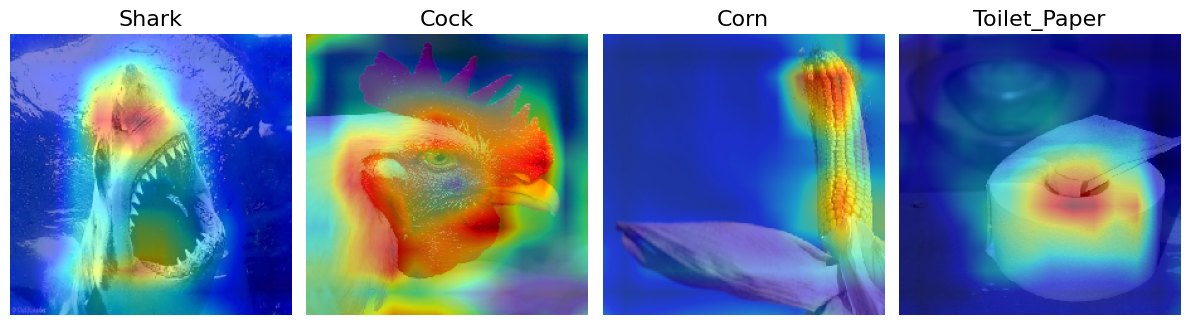

CPU times: user 2.05 s, sys: 761 ms, total: 2.81 s
Wall time: 2.76 s


In [ ]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Создаем объект GradCAM++
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Генерируем тепловую карту с помощью GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()